<a href="https://colab.research.google.com/github/Jatchen/Machine-Learning/blob/main/0218_ML_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
data = pd.read_csv("/content/drive/MyDrive/0218_ML_HW5_Event_entry.csv")

# Q1 data explore and visualization

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 869 entries, 0 to 868
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Entry          869 non-null    int64  
 1   TicketClass    869 non-null    int64  
 2   Sex            869 non-null    object 
 3   Age            694 non-null    float64
 4   Price          869 non-null    int64  
 5   Order          869 non-null    int64  
 6   Name           869 non-null    object 
 7   Ticket Number  869 non-null    int64  
 8   Bank Balance   869 non-null    int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 61.2+ KB


<ipython-input-6-4bfaf4712a4c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = data.corr()


<Axes: >

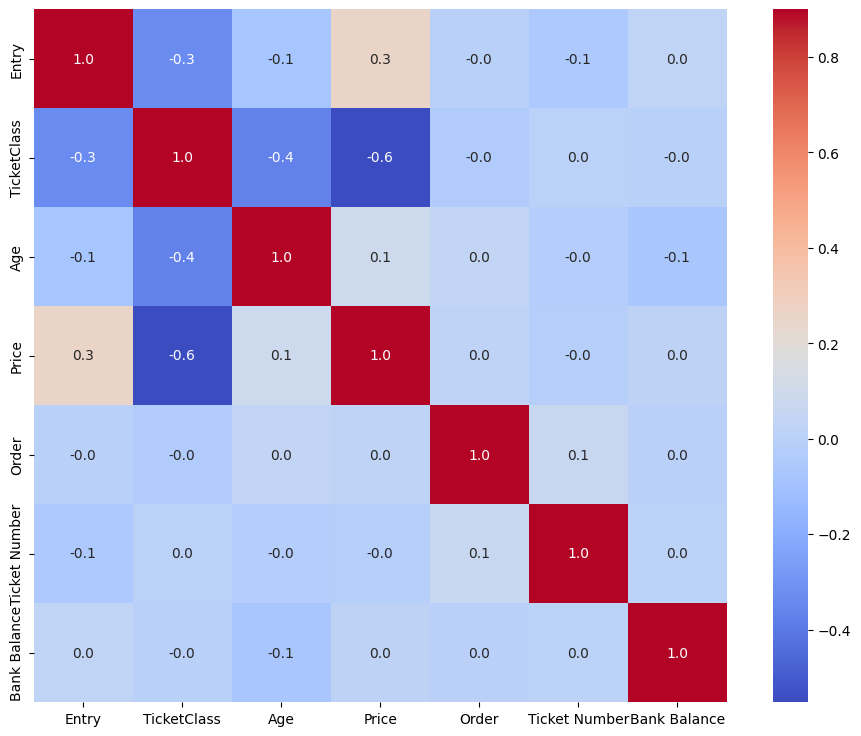

In [ ]:
# Plot the heatmap to understand correlation
corrmat = data.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, annot=True, fmt=".1f", cmap='coolwarm', vmax=0.9, square=True)

Insights:
we can see that ticketclass, age, price are correlated in different level, which makes PCA a suitable tool to analyze the relationship between variables.

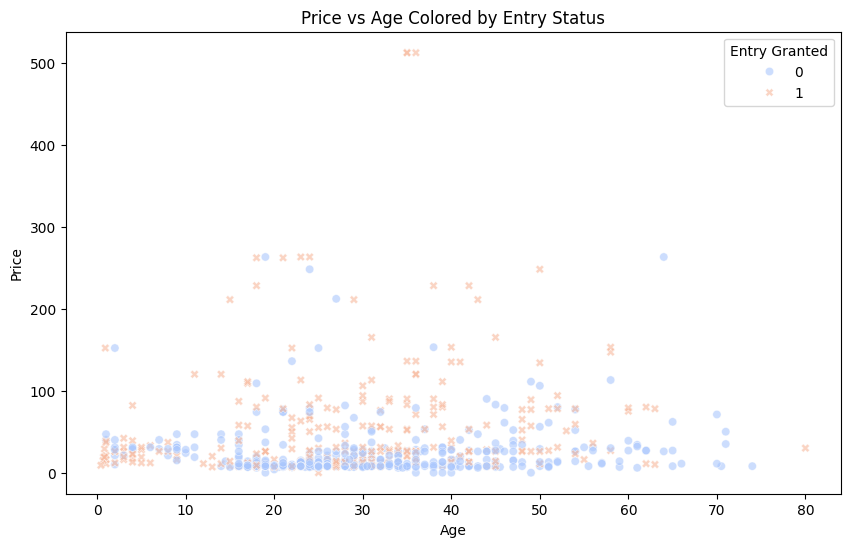

In [ ]:
# Scatter plot of Price vs Age, colored by Entry showing related pattern between age, ticket price that might influence entry decisions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Age', y='Price', hue='Entry', style='Entry', palette='coolwarm', alpha=0.6)
plt.title('Price vs Age Colored by Entry Status')
plt.xlabel('Age')
plt.ylabel('Price')
plt.legend(title='Entry Granted')
plt.show()


Insight:
we can see that people in the middle age tend to pay higher price for ticket.
There is no clear pattern shown between entry and age or price.

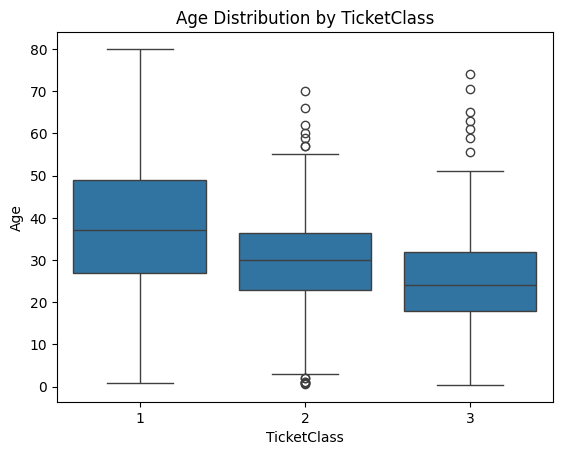

In [ ]:
# Box plot of Bank Balance by Entry Granted

sns.boxplot(x='TicketClass', y='Age', data=data)
plt.title('Age Distribution by TicketClass')
plt.show()

Insights:
This plot show that age do have relationship with ticketclass, however it is not very clear due to the overlap in the plot.

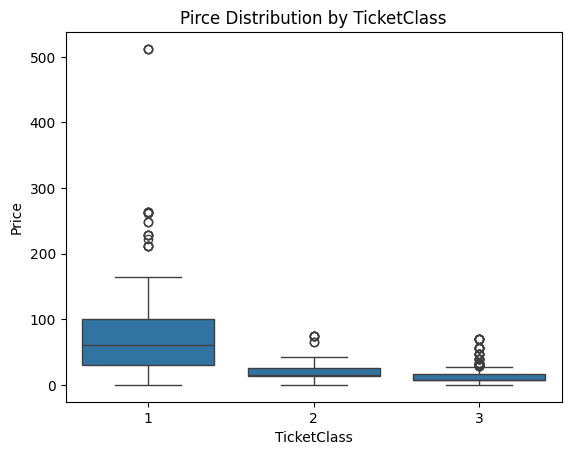

In [ ]:
# Box plot of Bank Balance by Entry Granted

sns.boxplot(x='TicketClass', y='Price', data=data)
plt.title('Pirce Distribution by TicketClass')
plt.show()

Insights:
This plot further approve the high correlation between ticketClass and price.

# Q2 PCA

Deal with missing value

In [4]:
# deal with missing value
missing_percentage = data.isnull().mean() * 100
missing_percentage

Entry             0.00000
TicketClass       0.00000
Sex               0.00000
Age              20.13809
Price             0.00000
Order             0.00000
Name              0.00000
Ticket Number     0.00000
Bank Balance      0.00000
dtype: float64

In [5]:
# Impute missing values in 'Age' with the mean
mean_age = data['Age'].mean()
data['Age'].fillna(mean_age, inplace=True)

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score


Deal with catergorical data

In [7]:
# Divide between categorical and numerical
categorical_variables = ['Sex', 'TicketClass']
numerical_variables = ['Age', 'Price', 'Bank Balance']
target_variable = 'Entry'

In [8]:
# Preprocessing for categorical and numerical data

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()) ## standardization the data
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_variables),
    ('cat', categorical_transformer, categorical_variables)])

# Apply preprocessing and split the data
X = data.drop([target_variable, 'Order', 'Name', 'Ticket Number'], axis=1)
y = data[target_variable]
X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

Run the model and record OOS performance

In [9]:
# Create dictionary to store accuracy scores
accuracies = {}

# Train and evaluate logistic regression models with PCA for different numbers of dimensions
for n_components in [2, 4, 6]:
    pipeline = Pipeline([
        ('pca', PCA(n_components=n_components)),
        ('logistic', LogisticRegression(max_iter=1000))
    ])
    pipeline.fit(X_train, y_train)
    accuracies[f'PCA_{n_components}_LR'] = pipeline.score(X_test, y_test)

# Train and evaluate a LASSO logistic regression model
lasso_model = LogisticRegressionCV(cv=5, penalty='l1', solver='saga', max_iter=5000)
lasso_model.fit(X_train, y_train)
accuracies['LASSO_LR'] = lasso_model.score(X_test, y_test)

# Print out the accuracy scores
for model, accuracy in accuracies.items():
    print(f"{model}: {accuracy:.4f}")

PCA_2_LR: 0.6667
PCA_4_LR: 0.7874
PCA_6_LR: 0.7989
LASSO_LR: 0.7989


Insight:
- For PCA, more features means more accuracy in this case. Because more information from the original dataset can be used to train the model. However, it does not prove that more variables are always the best. Because we need PCA to reduce dimension and capture the features of the original dataset, and more features will bring in noise in the model.
- Compared between PCA and Lasso, they have almost the same performance. It shows that in this case, different methods to reduce the dimension lead to the similar results.
- When choosing between different models, we should keep in mind that more variables not only improve accuracy, but also lead to overfitting problems and require more computational resources.



# Q3 Decision Tree Analysis

The steps we are taking to prepare the data and develop our model were as follows:
1. Use meean value for missing value in numerical columns.
2. For categorical data, we performed one-hot encoding to transform the variables.
3. Standardization the variable.
4. Removing irrelevant columns such as Order, Name, and Ticket Number.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the Decision Tree Classifier
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_dt = decision_tree_model.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)

# Print the accuracy
print(f"Accuracy of the Decision Tree Classifier: {accuracy_dt:.4f}")

Accuracy of the Decision Tree Classifier: 0.7011


Insight:  From the decision tree classifier, we achieved around 70.11% accuracy, which is slightly better than what we achieved with PCA with dimension 2, but not as high compared to PCA dimensions 4, 6, and the Lasso logistic regression model we had previously.

# Q4 K Means Clustering

In [10]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Step 1: Use only Age and Price columns
data_clustering = data[['Age', 'Price']].dropna()

# Standardize features to have a mean of 0 and variance of 1
scaler = StandardScaler()
data_clustering_scaled = scaler.fit_transform(data_clustering)


In [11]:
# Step 2: Perform K means clustering for different values of K to find the optimal K
sse = []
k_values = range(1, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_clustering_scaled)
    sse.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

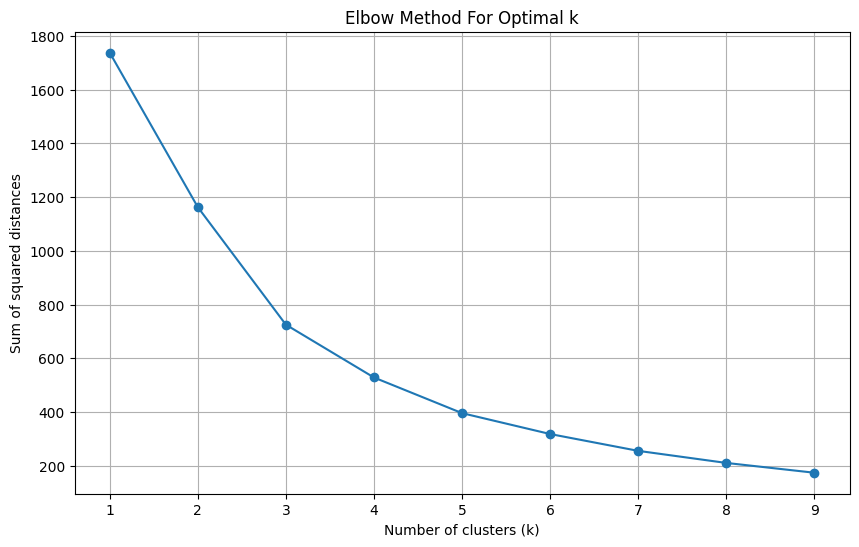

In [13]:
# Step 3: Draw a plot for choosing the optimal K using Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.xticks(k_values)
plt.grid(True)
plt.show()

Insight:
 there is a significant elbow around k is 3. This means that when we increase the number of clusters, it does not give a significant improvement to our model that represents by the sum of squared distance. Therefore we choose k = 3 in practice so that data will be optimal when it is divided into three clusters.

In [16]:
# we can see that the Elbow point is observed at k=3 for explanation purpose
k_optimal = 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


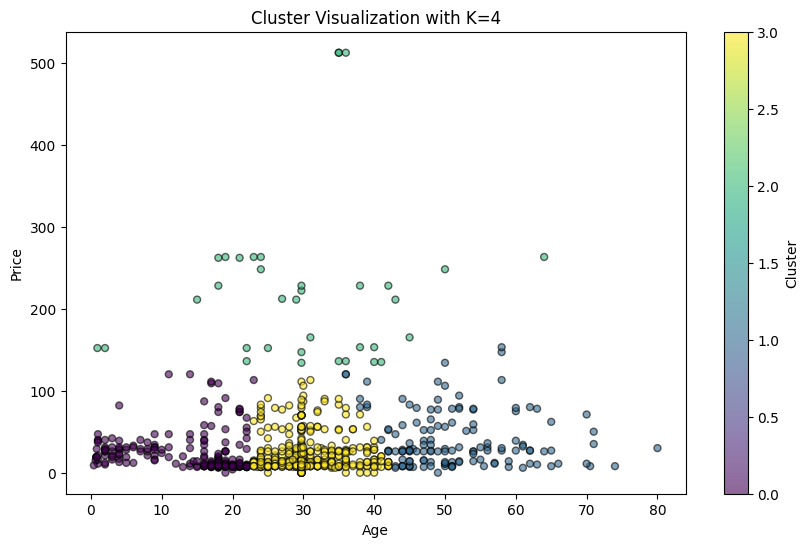

In [17]:
# Step 4: Create the clusters using the optimal value of K =3
kmeans_optimal = KMeans(n_clusters=k_optimal, random_state=42)
data_clustering['Cluster'] = kmeans_optimal.fit_predict(data_clustering_scaled)

# Step 5: Plot a graph for different clusters
plt.figure(figsize=(10, 6))
plt.scatter(data_clustering['Age'], data_clustering['Price'], c=data_clustering['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=25, alpha=0.6)
plt.title('Cluster Visualization with K={}'.format(k_optimal))
plt.xlabel('Age')
plt.ylabel('Price')
plt.colorbar(label='Cluster')
plt.show()